
*Pontifica Universidad Javeriana*

 *DPTO Ing Sistemas*

 **Materia** Procesamiento de Datos a Gran Escala

 **Autores:** Daniel Torres, Daniel Sandoval e Isaac Janica

**Fecha:**




In [2]:
# Se importan de las bibliotecas necesarias
import pyspark
from pyspark import SparkContext  #Importa la clase Spark context
from pyspark.sql import SQLContext, Row, Column #SqlContext permite poder hacer queries y operaciones con DataFrames de spark
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd

from pyspark.ml.feature import DenseVector, StandardScaler

import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


# File location and type
file_location = "cleaned_collisions.csv"
file_type = "csv"


# Create SparkSession
spark = SparkSession.builder \
    .appName("YourAppName") \
    .getOrCreate()

#colli_pd = pd.read_csv(file_location)
# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
# Read CSV file into a Spark DataFrame
df = spark.read.csv(file_location, header=first_row_is_header, inferSchema=infer_schema, sep=delimiter)
dfp = df.toPandas()
df.limit(4).toPandas()

#print(colli_pd)

ConnectionRefusedError: [Errno 111] Connection refused

## **Colección y descripción de los datos:**
En este apartado se realiza la carga de los datos y se describen los datos según los siguientes elementos:
- Tamaño: número de columnas y de filas.
- Su tipo.
- Nombre.

Todo esto se puede ver más a fondo en el informe:
https://docs.google.com/document/d/1m7ay9uNr1dauOqrrx8NblZEC2QaYxdmR/edit?rtpof=true



In [ ]:
df.dtypes

[('UNIQUE_ID', 'string'),
 ('COLLISION_ID', 'string'),
 ('CRASH_DATE', 'string'),
 ('CRASH_TIME', 'string'),
 ('VEHICLE_ID', 'string'),
 ('STATE_REGISTRATION', 'string'),
 ('VEHICLE_TYPE', 'string'),
 ('VEHICLE_MAKE', 'string'),
 ('VEHICLE_MODEL', 'string'),
 ('VEHICLE_YEAR', 'string'),
 ('TRAVEL_DIRECTION', 'string'),
 ('VEHICLE_OCCUPANTS', 'string'),
 ('DRIVER_SEX', 'string'),
 ('DRIVER_LICENSE_STATUS', 'string'),
 ('DRIVER_LICENSE_JURISDICTION', 'string'),
 ('PRE_CRASH', 'string'),
 ('POINT_OF_IMPACT', 'string'),
 ('VEHICLE_DAMAGE', 'string'),
 ('VEHICLE_DAMAGE_1', 'string'),
 ('VEHICLE_DAMAGE_2', 'string'),
 ('VEHICLE_DAMAGE_3', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE_TYPE', 'string'),
 ('CONTRIBUTING_FACTOR_1', 'string'),
 ('CONTRIBUTING_FACTOR_2', 'string')]

In [ ]:
print("Num columnas", len(df.columns))
print("Num filas", df.count())

Num columnas 25
Num filas 4154748


In [ ]:
# Print statement
print("Nulos por columna dentro del dataset de Collisions")

# Create a list to store the null counts
null_counts = []

# Iterate over each column to count null values
for col_name in df.columns:
    # Count the null values in the column
    null_count = df.select(col(col_name)).where(col(col_name).isNull()).count()
    # Append the null count to the list
    null_counts.append((col_name, null_count))

# Convert the null counts list to a PySpark DataFrame
null_counts_df = spark.createDataFrame(null_counts, ["Column Name", "Null Count"])

# Display the DataFrame
null_counts_df.show(null_counts_df.count(), truncate=False)

Nulos por columna dentro del dataset de Collisions


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:103)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:103)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

## Comprensión del significado de cada atributos:
En este caso, se hizo un diccionario de datos del cuál se tiene el siguiente link con el tipo de dato y la descripción de este:
https://docs.google.com/spreadsheets/d/1qxFz3B2A_1QBr87w9vNeHROOM842oU2F/edit#gid=1666817735


Lo diccionarios contienen el tipo de datos de cada atributo, a que hacen alusión y puede que en algunos casos, que columnas no se encuentran a pesar de que fueron parte de la misma tabla en el DBMS.

## **Descripción general del contenido de los conjuntos de datos:**


**Lo que se encontró en el conjunto de datos  fue:**
- El DataSet cuenta con 25 columnas y 4154748, un número bastante grande y que genera el tiempo de procesamiento de este sea mucho mayor que el DataSet de arrestos.
- Se cuenta con columnas como CRASH_DATE y CRASH_TIME que actualmente de tipo tiempo pero que pueden ser convertidas en en tipo Date y tipo Time. También hay otras variables en dónde estas son de tipo objeto pero podrían ser convertidas a variable de tipo numérico.
- Con una revisión a priori, el dataset presenta varias columnas con una enorme cantidad de nulos (hay columnas dónde el 50% o más de los registros son valores nulos).
- Este DataSet cuenta con 3 tipos diferentes de ID COLLISION_ID, UNIQUE_ID Y VEHICLE_ID. Dentro del diccionario de datos se explica que esto es debido a que esta tabla/DataSet es el resultado de un JOIN hecho entre dos tablas de una base de datos de la NYPD.
- Las columnas que no se entienden a priori son las de CONTRIBUTING_FACTOR.


# **Exploración de los datos:**

 En ese apartado se proccede a hacer uso de estadística descriptiva para tener una idea general de los datos por columnas. Las columnas que se van a estudiar son todas aquellas que no son 'llaves primarias', es decir, que su uso no es poder diferenciar un registro de otro.
Se hará uso de histogramas, diagramas de pie y diagramas de líneas para poder graficar las diferentes variables. En el caso de las variables cualitativas se va a utilizar el diagrama de pie, en en el caso de las variables discretas se va a hacer uso diagramas de línea y de histogramas.


In [ ]:
print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

/root/.ipykernel/878/command-2776222719623687-3198706491:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_states = top_states.append(pd.Series({f'Otros ({len(sorted_counts[k:])})': otros_count}))


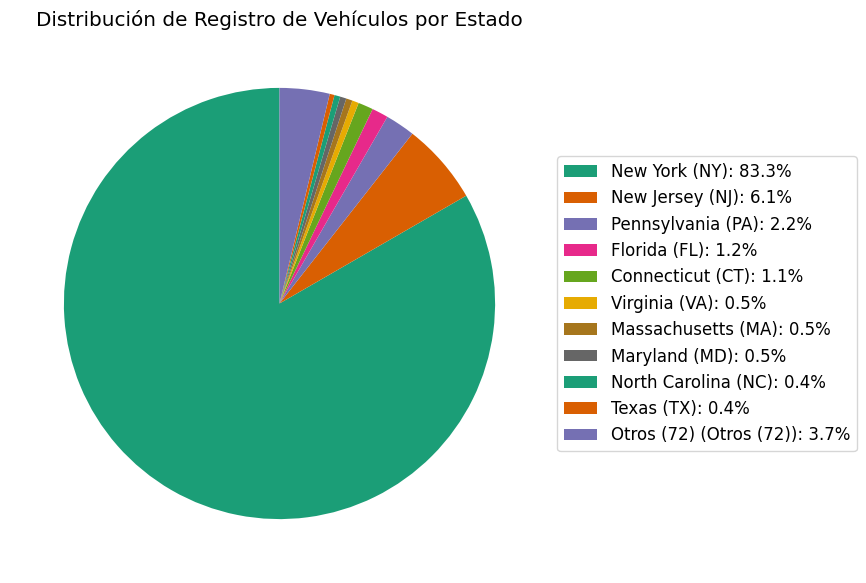

In [ ]:
value_counts = dfp.groupby('STATE_REGISTRATION').size()

# Supongamos que 'value_counts' es tu serie de conteos de registros por estado
sorted_counts = value_counts.sort_values(ascending=False)
k = 10

# Obtener las 10 categorías más frecuentes
top_states = sorted_counts.head(k)

# Sumar los conteos de los estados que no están en los 10 más frecuentes y colocarlos en "Otros"
otros_count = sorted_counts[k:].sum()
top_states = top_states.append(pd.Series({f'Otros ({len(sorted_counts[k:])})': otros_count}))

# Calcular porcentaje de cada categoría
percentages = 100 * top_states / top_states.sum()

# Crear la figura y el gráfico
plt.figure(figsize=(9, 7))

# Definir una paleta de colores más oscura para las categorías más grandes
colors = plt.cm.Dark2.colors[:len(top_states)]


state_labels = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

labels = [state_labels.get(label, label) for label in top_states.index]


# Graficar el pastel sin porcentajes ni etiquetas
wedges, _ = plt.pie(percentages, labels=None, startangle=90, colors=colors)

# Añadir etiquetas fuera del pastel con nombres y porcentajes
label_texts = [f"{state_long_name} ({state}): {percentage:.1f}%" for state, percentage, state_long_name in zip(top_states.index, percentages, labels)]
plt.legend(wedges, label_texts, loc="center left", fontsize='large', bbox_to_anchor=(1, 0, 0.5, 1))

# Añadir título
plt.title("Distribución de Registro de Vehículos por Estado", fontsize='x-large')

# Mostrar el gráfico
plt.show()

In [ ]:
# value_counts = dfp.groupby('STATE_REGISTRATION').size().sort_values(ascending=False)
# value_counts_2 = value_counts[1:]
# plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
# plt.pie(value_counts_2.values, labels=value_counts_2.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Registro del Vehículo por Estado")
# plt.tight_layout()
# plt.show()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

In [ ]:
#value_counts = df.groupBy('STATE_REGISTRATION').count()
#value_counts_pd = value_counts.toPandas()
#plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
#plt.pie(value_counts_pd['count'], labels=value_counts_pd['STATE_REGISTRATION'], autopct="%1.1f%%")  # Format as percentage
#plt.title("Registro del Vehículo por Estado")
#plt.tight_layout()
#plt.show()

# value_counts = dfp.groupby('STATE_REGISTRATION').size()

# plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Registro del Vehículo por Estado")
# plt.tight_layout()
# plt.show()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

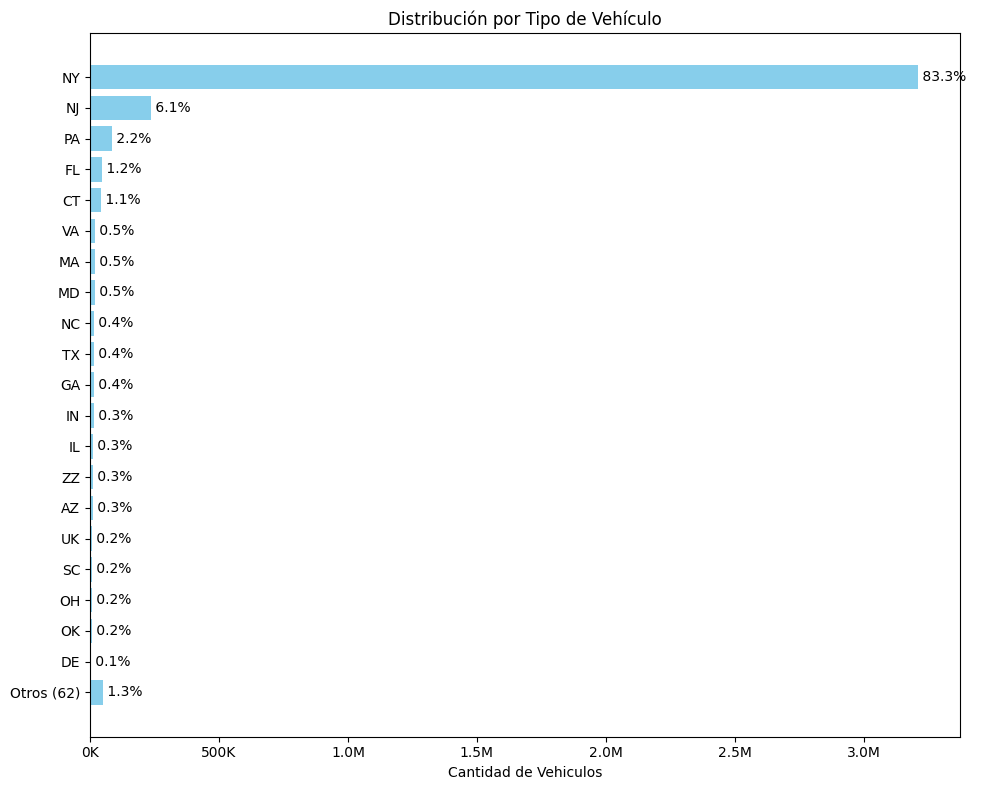

In [ ]:
import matplotlib.ticker as ticker

# Supongamos que ya tienes definidas las variables value_counts y sorted_counts

# Obtener las 10 categorías más frecuentes
top_categories = sorted_counts.head(20)

# Sumar los conteos de las categorías que no están en las 10 más frecuentes y colocarlos en "Otros"
otros_count = sorted_counts[20:].sum()
top_categories[f'Otros ({len(sorted_counts[20:])})'] = otros_count

# Crear un gráfico de barras horizontales con las categorías organizadas de mayor a menor
plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura según sea necesario
bars = plt.barh(top_categories.index, top_categories.values, color='skyblue')  # Gráfico de barras horizontal

plt.xlabel('Cantidad de Vehiculos')  # Etiqueta del eje x
plt.title('Distribución por Tipo de Vehículo')  # Título del gráfico
plt.gca().invert_yaxis()  # Invertir el eje y para que aparezcan los índices en orden descendente

# Cambiar el formato del eje x a mostrar K (miles) o M (millones)
formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}K'.format(x * 1e-3) if x < 1_000_000 else '{:.1f}M'.format(x * 1e-6))
plt.gca().xaxis.set_major_formatter(formatter)

# Mostrar los porcentajes en las barras
for bar in bars:
    yval = bar.get_height()  # Obtener la altura de la barra
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {bar.get_width() / sorted_counts.sum() * 100:.1f}%  ', 
             va='center')  # Mostrar el texto con el porcentaje

plt.tight_layout()  # Ajustar el diseño para evitar cortes
plt.show()

In [ ]:

# value_counts = dfp.groupby('VEHICLE_TYPE').size()

# plt.figure(figsize=(16, 14))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Distribución por Tipo de Vehículo")
# plt.tight_layout()
# plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

<Figure size 1300x1000 with 0 Axes>

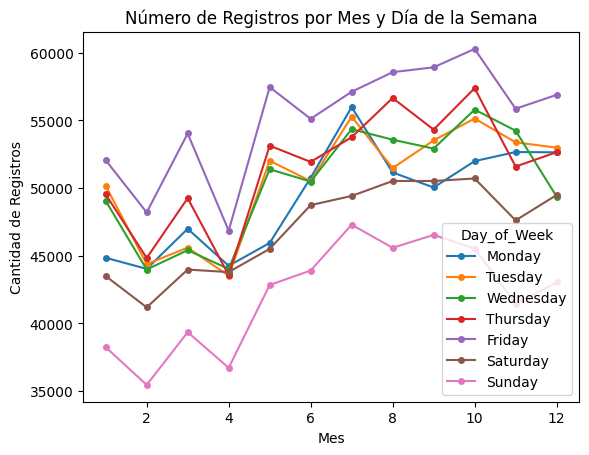

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623698>, line 19
     17 plt.xlabel('Mes')
     18 plt.ylabel('Cantidad de Registros')
---> 19 plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)])  # Para etiquetar meses
     20 plt.grid(True)
     21 plt.tight_layout(pad=4.0)

File <command-2776222719623698>, line 19, in <listcomp>(.0)
     17 plt.xlabel('Mes')
     18 plt.ylabel('Cantidad de Registros')
---> 19 plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)])  # Para etiquetar meses
     20 plt.grid(True)
     21 plt.tight_layout(pad=4.0)

NameError: name 'calendar' is not defined

In [ ]:
# Agrupar por mes y día de la semana
dfp['CRASH_DATE'] = pd.to_datetime(dfp['CRASH_DATE'])
dfp['Month'] = dfp['CRASH_DATE'].dt.month
dfp['Day_of_Week'] = dfp['CRASH_DATE'].dt.day_name()

# Calcular el conteo de registros por mes y día de la semana
register_count = dfp.groupby(['Month', 'Day_of_Week']).size().unstack()

# Ordenar los días de la semana en orden lógico
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
register_count = register_count.reindex(columns=days_order)

# Graficar
plt.figure(figsize=(13, 10))
register_count.plot(kind='line', marker='o', markersize=4, linestyle='-')
plt.title('Número de Registros por Mes y Día de la Semana')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)])  # Para etiquetar meses
plt.grid(True)
plt.tight_layout(pad=4.0)  # Ajustar el espaciado general del gráficoplt.show()

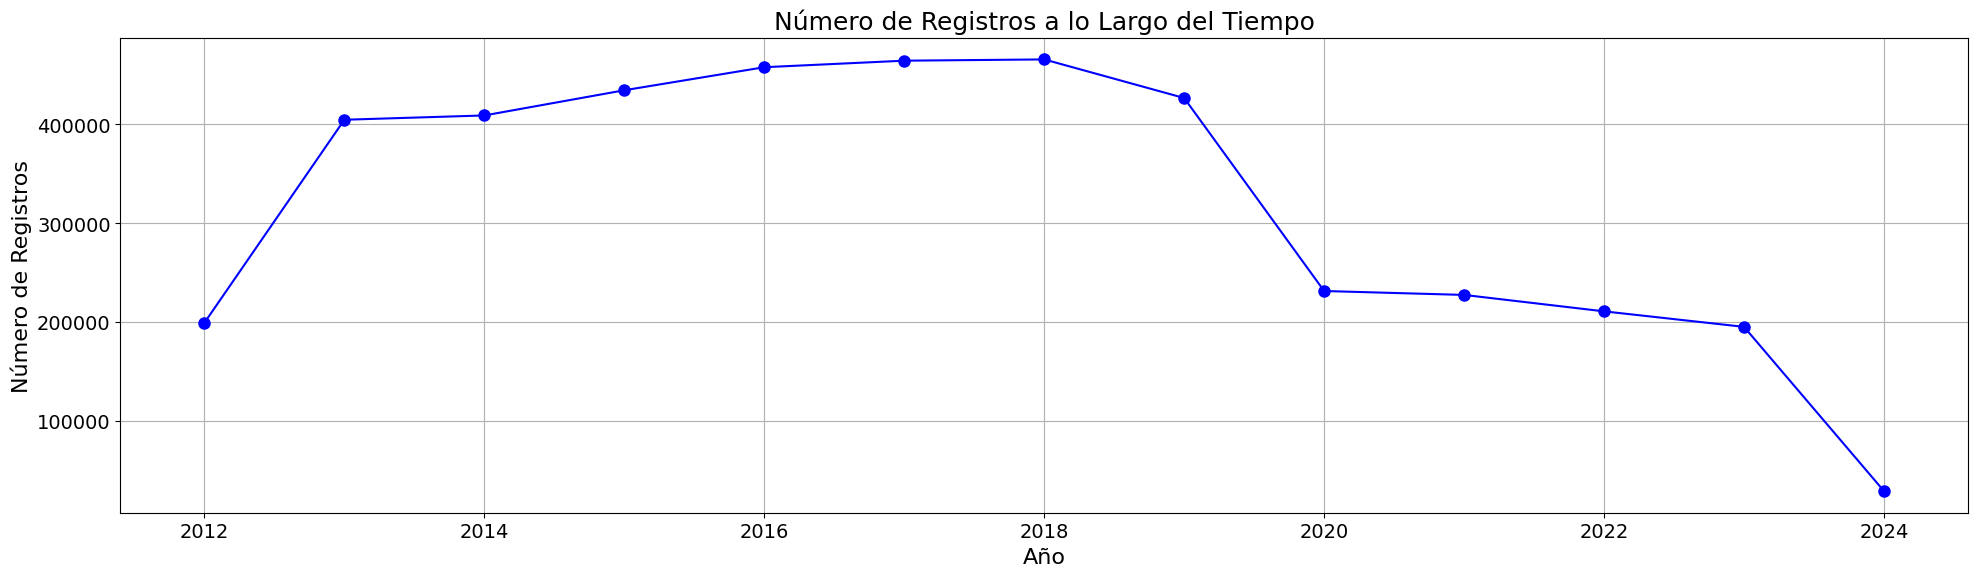

In [ ]:
# Supongamos que `dfp` es tu DataFrame y `CRASH_DATE` es una columna de fechas
dfp['CRASH_DATE'] = pd.to_datetime(dfp['CRASH_DATE'])
register_count_by_year = dfp.groupby(dfp['CRASH_DATE'].dt.year).size()

# Establecer tamaño de la figura y ajustar el tamaño de la fuente
plt.figure(figsize=(20, 6))  # Ajusta el ancho y la altura de la figura según tus necesidades
plt.rcParams.update({'font.size': 14})  # Establece el tamaño de la fuente

# Graficar los datos
register_count_by_year.plot(kind='line', color='blue', marker='o', markersize=8, linestyle='-')

# Configurar título y etiquetas
plt.title('Número de Registros a lo Largo del Tiempo', fontsize=18)  # Título más grande
plt.xlabel('Año', fontsize=16)  # Etiqueta del eje x más grande
plt.ylabel('Número de Registros', fontsize=16)  # Etiqueta del eje y más grande
plt.grid(True)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
# dfp['CRASH_DATE'] = pd.to_datetime(dfp['CRASH_DATE'])
# register_count = dfp.groupby('CRASH_DATE').size()


# plt.figure(figsize=(16, 14))
# register_count.plot(kind='line', color='blue', marker='o', markersize=4, linestyle='-')
# plt.title('Number of Registers Over Time')
# plt.xlabel('Date')
# plt.ylabel('Number of Registers')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

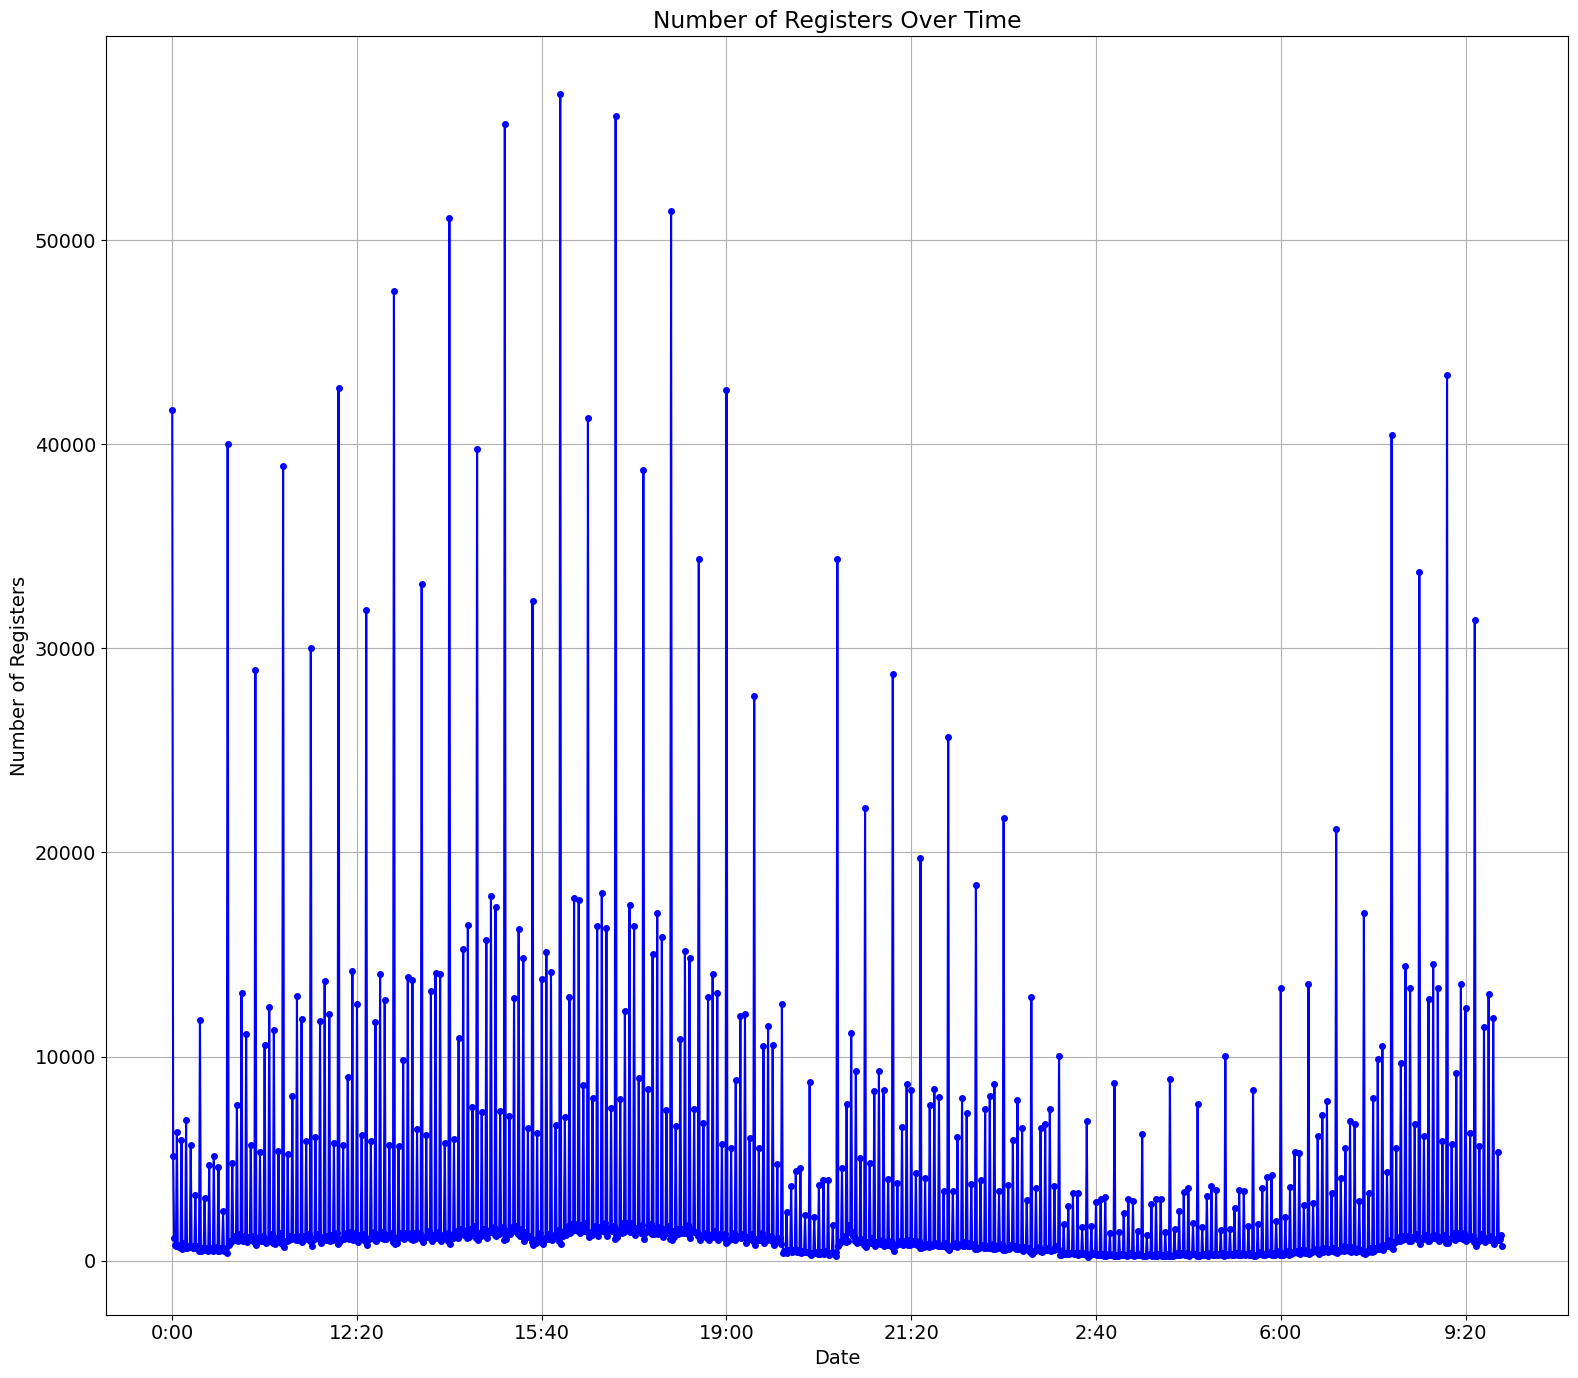

In [ ]:
register_count = dfp.groupby('CRASH_TIME').size()

plt.figure(figsize=(16, 14))
register_count.plot(kind='line', color='blue', marker='o', markersize=4, linestyle='-')
plt.title('Number of Registers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Registers')
plt.grid(True)
plt.tight_layout()
plt.show()

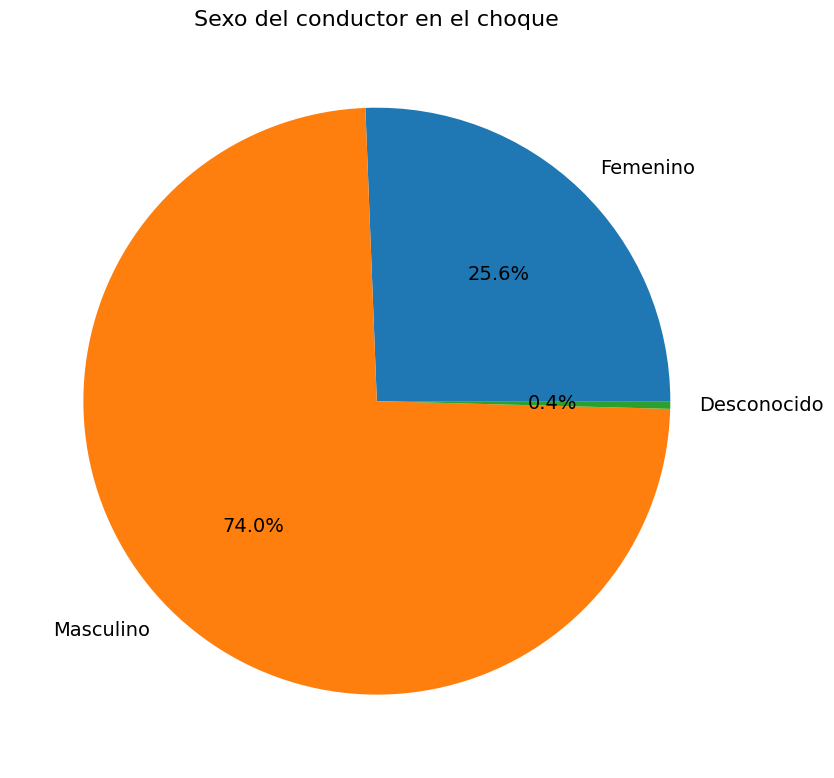

In [ ]:
# Calcular value_counts para PERP_SEX
value_counts = dfp.groupby('DRIVER_SEX').size()

# Renombrar las etiquetas según tus especificaciones
gender_labels = {'F': 'Femenino', 'M': 'Masculino', 'U': 'Desconocido'}
labels = [gender_labels.get(label, label) for label in value_counts.index]

# Configurar el tamaño del gráfico y otros parámetros
plt.figure(figsize=(10, 8))  # Ajustar el tamaño según sea necesario
plt.pie(value_counts.values, labels=labels, autopct="%1.1f%%", textprops={'fontsize': 14})  # Ajustar el tamaño del texto
plt.title("Sexo del conductor en el choque", fontsize=16)  # Ajustar el título
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:

# value_counts = dfp.groupby('DRIVER_SEX').size()

# plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
# plt.pie(value_counts.values, labels=value_counts.index, autopct="%1.1f%%")  # Format as percentage
# plt.title("Sexo del conductor en el choque")
# plt.tight_layout()
# plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

#Eliminación de valores nulos




In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import *

pairs = df.select("STATE_REGISTRATION", "DRIVER_LICENSE_JURISDICTION").distinct() \
    .filter(df.STATE_REGISTRATION.isNotNull() & df.DRIVER_LICENSE_JURISDICTION.isNotNull()).collect()

# Construct a dictionary to store the relations
relations_dict = {}
for row in pairs:
    pd_cd = row["STATE_REGISTRATION"]
    ky_cd = row["DRIVER_LICENSE_JURISDICTION"]
    if pd_cd not in relations_dict:
        relations_dict[pd_cd] = ky_cd

# Print the dictionary
print("Relations:")
for pd_cd, ky_cd in relations_dict.items():
    print(f"STATE_REGISTRATION: {pd_cd} -> DRIVER_LICENSE_JURISDICTION: {ky_cd}")

# Broadcast the dictionary
broadcasted_dict = spark.sparkContext.broadcast(relations_dict)

# UDF to fill null values
def fill_null_with_dict(value):
    relations_dict = broadcasted_dict.value
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(fill_null_with_dict, StringType())

# Apply UDF to fill null values
df_filled = df.withColumn("DRIVER_LICENSE_JURISDICTION", 
                          when(col("DRIVER_LICENSE_JURISDICTION").isNull(), 
                               fill_null_with_dict_udf(col("STATE_REGISTRATION"))
                              ).otherwise(col("DRIVER_LICENSE_JURISDICTION")))

# Count null values in DRIVER_LICENSE_JURISDICTION
nulls_count_ky_cd = df_filled.filter(col("DRIVER_LICENSE_JURISDICTION").isNull()).count()

# Print the count
print("Number of null values in KY_CD:", nulls_count_ky_cd)

# Show DataFrame
df = df_filled

Relations:
STATE_REGISTRATION: DC -> DRIVER_LICENSE_JURISDICTION: NC
STATE_REGISTRATION: SC -> DRIVER_LICENSE_JURISDICTION: PA
STATE_REGISTRATION: MN -> DRIVER_LICENSE_JURISDICTION: IL
STATE_REGISTRATION: IN -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: ME -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: NB -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: CT -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: MO -> DRIVER_LICENSE_JURISDICTION: MO
STATE_REGISTRATION: OK -> DRIVER_LICENSE_JURISDICTION: TX
STATE_REGISTRATION: OH -> DRIVER_LICENSE_JURISDICTION: CT
STATE_REGISTRATION: PA -> DRIVER_LICENSE_JURISDICTION: MX
STATE_REGISTRATION: ID -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: GA -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: NJ -> DRIVER_LICENSE_JURISDICTION: TN
STATE_REGISTRATION: RI -> DRIVER_LICENSE_JURISDICTION: CA
STATE_REGISTRATION: NC -> DRIVER_LICENSE_JURISDICTION: ND
STATE_REGISTRATION: FL -> DRIVER_LICENSE_JURISDICTION: CA
STA

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

In [ ]:
#Se reemplaza el modelo basado en el tipo de vehículo, se hace un diccionario que ayuda a reemplazar
pairs = df.select("VEHICLE_TYPE", "MODEL").distinct().filter(df.VEHICLE_TYPE.isNotNull() & df.MODEL.isNotNull()).collect()


relations_dict = {}
for row in pairs:
    vehicle_type = row["VEHICLE_TYPE"]
    model = row["MODEL"]
    if vehicle_type not in relations_dict:
        relations_dict[vehicle_type] = []
    relations_dict[vehicle_type].append(model)

# Print the dictionary
print("Relations:")
for vehicle_type, model_list in relations_dict.items():
    print(f"VEHICLE_TYPE: {vehicle_type} -> MODEL: {model_list}")

def fill_null_with_dict(value, relations_dict):
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(lambda x: fill_null_with_dict(x, relations_dict), StringType())


df_filled = df.withColumn("MODEL", when(col("MODEL").isNull(), fill_null_with_dict_udf(col("VEHICLE_TYPE"))).otherwise(col("MODEL")))

nulls_count_ky_cd = df_filled.filter(col("MODEL").isNull()).count()

# Print the count
print("Number of null values in MODEL:", nulls_count_ky_cd)

df = df_filled

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2776222719623576>, line 2
      1 #Se reemplaza el modelo basado en el tipo de vehículo, se hace un diccionario que ayuda a reemplazar
----> 2 pairs = df.select("VEHICLE_TYPE", "MODEL").distinct().filter(df.VEHICLE_TYPE.isNotNull() & df.MODEL.isNotNull()).collect()
      5 relations_dict = {}
      6 for row in pairs:

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:3832, in DataFrame.select(self, *cols)
   3787 def select(self, *cols: "ColumnOrName"

#Limpieza de Datos




### Inputación de datos en la columnas 'DRIVER_LICENSE_JURISDICTION' basado en valores de la columna 'STATE_REGISTRATION'

En este apartado se crea un diccionario en dónde se va a almacenar los valores equivalente de STATE_REGISTRATION para DRIVER_LICENSE_JURISDICTION debido a que esta última columna cuenta con más valores nulos que la primera. Con esto se espera que al momento de haber un nulo en DRIVER_LICENSE_JURISDICTION, este sea rellenado usando un diccionario que almacena una "tabla de equivalencias" entre los valores de STATE_REGISTRATION y DRIVER_LICENSE_JURISDICTION. Por ejemplo digamos que el diccionario alamcena que {NY: NY, DC: DC} y encuentra que el valor en DRIVER_LICENSE_JURISDICTION es nulo pero que en STATE_REGISTRATION es NY, entonces va a reemplazar el valor faltante por NY. 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import *

pairs = df.select("STATE_REGISTRATION", "DRIVER_LICENSE_JURISDICTION").distinct() \
    .filter(df.STATE_REGISTRATION.isNotNull() & df.DRIVER_LICENSE_JURISDICTION.isNotNull()).collect()

# Construct a dictionary to store the relations
relations_dict = {}
for row in pairs:
    pd_cd = row["STATE_REGISTRATION"]
    ky_cd = row["DRIVER_LICENSE_JURISDICTION"]
    if pd_cd not in relations_dict:
        relations_dict[pd_cd] = ky_cd

# Print the dictionary
print("Relations:")
for pd_cd, ky_cd in relations_dict.items():
    print(f"STATE_REGISTRATION: {pd_cd} -> DRIVER_LICENSE_JURISDICTION: {ky_cd}")

# Broadcast the dictionary
broadcasted_dict = spark.sparkContext.broadcast(relations_dict)

# UDF to fill null values
def fill_null_with_dict(value):
    relations_dict = broadcasted_dict.value
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(fill_null_with_dict, StringType())

# Apply UDF to fill null values
df_filled = df.withColumn("DRIVER_LICENSE_JURISDICTION", 
                          when(col("DRIVER_LICENSE_JURISDICTION").isNull(), 
                               fill_null_with_dict_udf(col("STATE_REGISTRATION"))
                              ).otherwise(col("DRIVER_LICENSE_JURISDICTION")))

# Count null values in DRIVER_LICENSE_JURISDICTION
nulls_count_ky_cd = df_filled.filter(col("DRIVER_LICENSE_JURISDICTION").isNull()).count()

# Print the count
print("Number of null values in KY_CD:", nulls_count_ky_cd)

# Show DataFrame
df = df_filled

Relations:
STATE_REGISTRATION: SC -> DRIVER_LICENSE_JURISDICTION: PA
STATE_REGISTRATION: DC -> DRIVER_LICENSE_JURISDICTION: NC
STATE_REGISTRATION: MN -> DRIVER_LICENSE_JURISDICTION: IL
STATE_REGISTRATION: ME -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: IN -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: NB -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: MO -> DRIVER_LICENSE_JURISDICTION: MO
STATE_REGISTRATION: PA -> DRIVER_LICENSE_JURISDICTION: MX
STATE_REGISTRATION: CT -> DRIVER_LICENSE_JURISDICTION: FL
STATE_REGISTRATION: OH -> DRIVER_LICENSE_JURISDICTION: CT
STATE_REGISTRATION: OK -> DRIVER_LICENSE_JURISDICTION: TX
STATE_REGISTRATION: ID -> DRIVER_LICENSE_JURISDICTION: AL
STATE_REGISTRATION: FO -> DRIVER_LICENSE_JURISDICTION: FO
STATE_REGISTRATION: NJ -> DRIVER_LICENSE_JURISDICTION: TN
STATE_REGISTRATION: GA -> DRIVER_LICENSE_JURISDICTION: MA
STATE_REGISTRATION: RI -> DRIVER_LICENSE_JURISDICTION: CA
STATE_REGISTRATION: FL -> DRIVER_LICENSE_JURISDICTION: CA
STA

### Inputación de datos en la columnas 'VEHICLE_TYPE' basado en valores de la columna 'MODEL'

El proceso que se hizo es análogo al que se hizo en la anterior celda

In [ ]:
#Se reemplaza el modelo basado en el tipo de vehículo, se hace un diccionario que ayuda a reemplazar
pairs = df.select("VEHICLE_TYPE", "MODEL").distinct().filter(df.VEHICLE_TYPE.isNotNull() & df.MODEL.isNotNull()).collect()


relations_dict = {}
for row in pairs:
    vehicle_type = row["VEHICLE_TYPE"]
    model = row["MODEL"]
    if vehicle_type not in relations_dict:
        relations_dict[vehicle_type] = []
    relations_dict[vehicle_type].append(model)

# Print the dictionary
print("Relations:")
for vehicle_type, model_list in relations_dict.items():
    print(f"VEHICLE_TYPE: {vehicle_type} -> MODEL: {model_list}")

def fill_null_with_dict(value, relations_dict):
    return relations_dict.get(value, value)

fill_null_with_dict_udf = udf(lambda x: fill_null_with_dict(x, relations_dict), StringType())


df_filled = df.withColumn("MODEL", when(col("MODEL").isNull(), fill_null_with_dict_udf(col("VEHICLE_TYPE"))).otherwise(col("MODEL")))

nulls_count_ky_cd = df_filled.filter(col("MODEL").isNull()).count()

# Print the count
print("Number of null values in MODEL:", nulls_count_ky_cd)

df = df_filled

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2056946074123798>, line 2
      1 #Se reemplaza el modelo basado en el tipo de vehículo, se hace un diccionario que ayuda a reemplazar
----> 2 pairs = df.select("VEHICLE_TYPE", "MODEL").distinct().filter(df.VEHICLE_TYPE.isNotNull() & df.MODEL.isNotNull()).collect()
      5 relations_dict = {}
      6 for row in pairs:

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:3832, in DataFrame.select(self, *cols)
   3787 def select(self, *cols: "ColumnOrName"

### Separación de la columna 'VEHICLE_MAKE'

Se separa esta columan con el fin de poder separar el modelo del auto (la marca de este) y el tipo de auto que es (CAR/SUV, SEDAN, entre otros)

In [ ]:
from pyspark.sql.functions import split

# Split the VEHICLE_MAKE
df = df.withColumn("MAKE", split(df["VEHICLE_MAKE"], "-")[0]) \
       .withColumn("MODEL", split(df["VEHICLE_MAKE"], "-")[1])

# Drop  VEHICLE_MAKE 

# Stop the SparkSession
df.limit(5).toPandas()

UNIQUE_ID COLLISION_ID  CRASH_DATE  ... CONTRIBUTING_FACTOR_2   MAKE    MODEL
0  10385780       100201  09/07/2012  ...                  None   None     None
1  19140702      4213082  09/23/2019  ...           Unspecified  TOYT   CAR/SUV
2  14887647      3307608  10/02/2015  ...                  None   None     None
3  14889754      3308693  10/04/2015  ...                  None   None     None
4  14400270       297666  04/25/2013  ...                  None   None     None

[5 rows x 27 columns]

### Eliminación de columnas

In [ ]:
#Se elimina la columna model porque la columnas Vehicle type aporta la misma información con menor cantidad de nulos
df = df.drop('MODEL')
# Se van a eliminar las siguientes columnas debido a que no se van a usar para el análisis
df = df.drop("VEHICLE_MAKE")
df = df.drop('UNIQUE_ID')
df = df.drop('VEHICLE_ID')
df = df.drop('PUBLIC_PROPERTY_DAMAGE')
df = df.drop('PUBLIC_PROPERTY_DAMAGE_TYPE')
df = df.drop('VEHICLE_MODEL')


### Estandarización de la columna CRASH_TIME

Lo primero que se hizo fue convertir las horas a que estas pertenezcan a 'una hora específica', es decir, ahora ya no se van a contar con horas que terminen en números diferentes a cero y solo se van a contar con las horas :00 o las horas :30. En este sentido algo que se encuentre en las horas :00 es una hroa que esté entre las :46 y las y 15, mientras que algo que se encuentre en las horas :30 son hroas que están entre las :16 y las :45. 

In [ ]:
def round_time(time):
    hour, minute = map(int, time.split(':'))
    if 15 < minute <= 45:
        minute = 30
    else:
        minute = 0
        if minute == 0 and hour == 23:
            hour = 0
        else:
            hour = (hour + 1) if minute == 0 else hour
    return f"{hour:02d}:{minute:02d}"
    
print(round_time('10:29')) 

# Register UDF
round_time_udf = udf(round_time, StringType())

# Apply UDF to CRASH_TIME column
df = df.withColumn("CRASH_TIME", round_time_udf("CRASH_TIME"))
df.limit(4).toPandas()


10:30


COLLISION_ID  CRASH_DATE  ... CONTRIBUTING_FACTOR_2   MAKE
0       100201  09/07/2012  ...                  None   None
1      4213082  09/23/2019  ...           Unspecified  TOYT 
2      3307608  10/02/2015  ...                  None   None
3      3308693  10/04/2015  ...                  None   None

[4 rows x 20 columns]

In [ ]:
def round_time(time):
    hour, minute = map(int, time.split(':'))
    if 15 < minute <= 45:
        minute = 30
    else:
        minute = 0
        if minute == 0 and hour == 23:
            hour = 0
        else:
            hour = (hour + 1) if minute == 0 else hour
    return f"{hour:02d}:{minute:02d}"
    
print(round_time('10:29')) 


# Apply function to CRASH_TIME column
dfp['CRASH_TIME'] = dfp['CRASH_TIME'].apply(round_time)

# Show the result
display(dfp)



10:30


UNIQUE_ID COLLISION_ID CRASH_DATE CRASH_TIME VEHICLE_ID STATE_REGISTRATION VEHICLE_TYPE VEHICLE_MAKE VEHICLE_MODEL VEHICLE_YEAR TRAVEL_DIRECTION VEHICLE_OCCUPANTS DRIVER_SEX DRIVER_LICENSE_STATUS DRIVER_LICENSE_JURISDICTION PRE_CRASH POINT_OF_IMPACT VEHICLE_DAMAGE VEHICLE_DAMAGE_1 VEHICLE_DAMAGE_2 VEHICLE_DAMAGE_3 PUBLIC_PROPERTY_DAMAGE PUBLIC_PROPERTY_DAMAGE_TYPE CONTRIBUTING_FACTOR_1 CONTRIBUTING_FACTOR_2 Month Day_of_Week 10385780 100201 2012-09-07T00:00:00Z 10:00 1 NY PASSENGER VEHICLE null null null null null null null null null null null null null null null null Unspecified null 9 Friday 19140702 4213082 2019-09-23T00:00:00Z 09:00 0553ab4d-9500-4cba-8d98-f4d7f89d5856 NY Station Wagon/Sport Utility Vehicle TOYT -CAR/SUV null 2002 North 1 M Licensed NY Going Straight Ahead Left Front Bumper Left Front Quarter Panel null null null N null Driver Inattention/Distraction Unspecified 9 Monday 14887647 3307608 2015-10-02T00:00:00Z 17:30 2 NY TAXI null null null null null null null null Going Straight Ahead null null null null null null null Driver Inattention/Distraction null 10 Friday 14889754 3308693 2015-10-04T00:00:00Z 20:30 1 NY PASSENGER VEHICLE null null null null null null null null Parked null null null null null null null Unspecified null 10 Sunday 14400270 297666 2013-04-25T00:00:00Z 22:00 1 NY PASSENGER VEHICLE null null null null null null null null null null null null null null null null Other Vehicular null 4 Thursday 17044639 3434155 2016-05-02T00:00:00Z 17:30 219456 NY 4 dr sedan MERZ -CAR/SUV null 2015 East 2 M Licensed FL Merging Right Front Bumper Right Front Bumper Right Front Quarter Panel null null N null Driver Inattention/Distraction Unsafe Lane Changing 5 Monday 19138701 4229067 2019-10-24T00:00:00Z 14:00 c53b43d9-419a-4ab1-9361-3f2979078d89 NY Bus FRHT-TRUCK/BUS null 2006 East 13 M Licensed NY Parked Left Front Quarter Panel Left Front Quarter Panel null null null N null Unspecified Unspecified 10 Thursday 17303317 3503027 2016-08-18T00:00:00Z 12:30 672828 NY Station Wagon/Sport Utility Vehicle FORD -CAR/SUV null 2005 Southwest 2 F Licensed NY Going Straight Ahead Center Front End Center Front End No Damage No Damage No Damage N null Driver Inattention/Distraction Unspecified 8 Thursday 12254536 196425 2013-07-16T00:00:00Z 11:30 1 NY PASSENGER VEHICLE null null null null null null null null null null null null null null null null Unspecified null 7 Tuesday 11804847 2975897 2012-11-26T00:00:00Z 19:00 2 NY PASSENGER VEHICLE null null null null null null null null null null null null null null null null Driver Inattention/Distraction null 11 Monday 17285715 3487936 2016-07-22T00:00:00Z 15:30 554272 NY Convertible VOLK -CAR/SUV null 2013 South 1 M Licensed NY Stopped in Traffic Right Rear Bumper Right Rear Bumper Center Back End Left Rear Bumper null N null Unspecified Unspecified 7 Friday 14809587 3268858 2015-08-01T00:00:00Z 08:30 2 NJ PASSENGER VEHICLE null null null null null null null null Going Straight Ahead null null null null null null null Passenger Distraction null 8 Saturday 17307366 3499697 2016-08-13T00:00:00Z 22:00 650962 NY Sedan NISS -CAR/SUV null 2015 West 2 F Licensed NY Going Straight Ahead Left Side Doors Left Side Doors Left Rear Quarter Panel null null N null Unspecified Unspecified 8 Saturday 19140791 4229563 2019-10-21T00:00:00Z 18:00 86a294b4-6672-4a7e-8357-39d6d2eff9f7 PA Sedan BMW -CAR/SUV null 2006 North 2 F Licensed PA Going Straight Ahead Center Front End Right Front Bumper Right Front Quarter Panel Right Front Bumper null N null Unspecified Unspecified 10 Monday 19694316 4322767 2020-06-06T00:00:00Z 18:30 fdc195a7-8127-4c00-834d-bac78b0cf88e null Bike null null null South 1 M Licensed NY Going Straight Ahead Center Front End No Damage No Damage No Damage No Damage N null Traffic Control Disregarded Unspecified 6 Saturday 11912713 176016 2012-08-11T00:00:00Z 19:30 2 NY BICYCLE null null null null null null null null null null null null null null null null Unspecified null 8 S

### Creación de columnas basadas en los atributros de VEHICLE_DAMAGE, VEHICLE_DAMAGE_1, VEHICLE_DAMAGE_2 y VEHICLE_DAMAGE_3

Debido a que estas columnas cuentan con una enorme cantidad de valores nulos y también por el hecho de contienen los mismos datos valores para los datos, se decidió a partir de los valores de estos datos crear las columnas, después llenarlas utilizando los valores que tengan los VEHICLE_DAMAGE en esa fila por medio de valores binarios, 1 si contiene ese valor en alguna de las VEHICLE_DAMAGE, 0 si no.Posteriormente se hará la eliminación de estas columnas de VEHICLE_DAMAGE.


In [ ]:
distinct_values = df.select('VEHICLE_DAMAGE_1').distinct().collect()
distinct_values2 = df.select('VEHICLE_DAMAGE_2').distinct().collect()
distinct_values3 = df.select('VEHICLE_DAMAGE_3').distinct().collect()



# Print distinct values
print(f"All distinct values in column '{'Vehicle_Damage'}':")
for row in distinct_values:
    print(row["VEHICLE_DAMAGE_1"])

for row in distinct_values2:
    print(row['VEHICLE_DAMAGE_2'])

for row in distinct_values3:
    print(row['VEHICLE_DAMAGE_3'])


All distinct values in column 'Vehicle_Damage':
Left Rear Quarter Panel
Center Back End
Left Front Quarter Panel
None
Right Front Bumper
Left Rear Bumper
Right Side Doors
Roof
Right Front Quarter Panel
Other
Overturned
Trailer
Right Rear Quarter Panel
Left Side Doors
Left Front Bumper
Demolished
Center Front End
Undercarriage
Right Rear Bumper
No Damage
Left Rear Quarter Panel
Center Back End
Left Front Quarter Panel
None
Right Front Bumper
Left Rear Bumper
Right Side Doors
Roof
Right Front Quarter Panel
Other
Overturned
Trailer
Right Rear Quarter Panel
Left Side Doors
Left Front Bumper
Demolished
Center Front End
Undercarriage
Right Rear Bumper
No Damage
Left Rear Quarter Panel
Center Back End
Left Front Quarter Panel
None
Right Front Bumper
Left Rear Bumper
Right Side Doors
Roof
Right Front Quarter Panel
Other
Overturned
Trailer
Right Rear Quarter Panel
Left Side Doors
Left Front Bumper
Demolished
Center Front End
Undercarriage
Right Rear Bumper
No Damage


In [ ]:
# List of unique values
df_copy2 = df
unique_values = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel", "None", "Right Front Bumper",
    "Left Rear Bumper", "Right Side Doors", "Roof", "Right Front Quarter Panel", "Other", "Overturned",
    "Trailer", "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper", "Demolished", "Center Front End",
    "Undercarriage", "Right Rear Bumper", "No Damage"
]

# Create new columns for each unique value and populate them based on the original column
for value in unique_values:
    df_copy2 = df_copy2.withColumn(value.replace(" ", "_"), when(df_copy2["VEHICLE_DAMAGE_1"] == value, 1).otherwise(0))

df_copy2.limit(5).toPandas()

COLLISION_ID  CRASH_DATE  ... Right_Rear_Bumper No_Damage
0       100201  09/07/2012  ...                 0         0
1      4213082  09/23/2019  ...                 0         0
2      3307608  10/02/2015  ...                 0         0
3      3308693  10/04/2015  ...                 0         0
4       297666  04/25/2013  ...                 0         0

[5 rows x 40 columns]

In [ ]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE"] == damage_type), 1)
                       .otherwise(0))



---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2056946074123809>, line 17
     15 column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
     16 # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
---> 17 df = df.withColumn(column_name,
     18                    when((col(column_name) == 1) | (df["VEHICLE_DAMAGE"] == damage_type), 1)
     19                    .otherwise(0))

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/s

In [ ]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_1"] == damage_type), 1)
                       .otherwise(0))


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2056946074123810>, line 17
     15 column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
     16 # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
---> 17 df = df.withColumn(column_name,
     18                    when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_1"] == damage_type), 1)
     19                    .otherwise(0))

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark

In [ ]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_2"] == damage_type), 1)
                       .otherwise(0))



---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2056946074123811>, line 17
     15 column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
     16 # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
---> 17 df = df.withColumn(column_name,
     18                    when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_2"] == damage_type), 1)
     19                    .otherwise(0))

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark

In [ ]:
from pyspark.sql.functions import when, col

# List of possible damage types
damage_types = [
    "Left Rear Quarter Panel", "Center Back End", "Left Front Quarter Panel",
    "None", "Right Front Bumper", "Left Rear Bumper", "Right Side Doors",
    "Roof", "Right Front Quarter Panel", "Other", "Overturned", "Trailer",
    "Right Rear Quarter Panel", "Left Side Doors", "Left Front Bumper",
    "Demolished", "Center Front End", "Undercarriage", "Right Rear Bumper",
    "No Damage"
]

# Loop through each damage type and apply when condition to fill respective column
for damage_type in damage_types:
    column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
    # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
    df = df.withColumn(column_name,
                       when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_3"] == damage_type), 1)
                       .otherwise(0))


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2056946074123812>, line 17
     15 column_name = damage_type.replace(" ", "_")  # Convert damage type to column name format
     16 # Check if the column already has a value of 1, if so, retain it, otherwise, set based on VEHICLE_DAMAGE_1
---> 17 df = df.withColumn(column_name,
     18                    when((col(column_name) == 1) | (df["VEHICLE_DAMAGE_3"] == damage_type), 1)
     19                    .otherwise(0))

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark

In [ ]:
df.filter(col('VEHICLE_DAMAGE').isNotNull()).toPandas()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

In [ ]:
#Verificando que haya funcionado el cambio de valores a columnas binarias
df.filter(col('VEHICLE_DAMAGE_1').isNotNull()).toPandas()



---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

In [ ]:
df.filter(col('VEHICLE_DAMAGE_2').isNotNull()).toPandas()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

In [ ]:
df.filter(col('VEHICLE_DAMAGE_3').isNotNull()).toPandas()


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined

### Estandarización de variables
Se estandariza la fecha del choque a el tipo fecha, al igual que se pone en formato de tiempos la hora del accidente,el número de ocupantes se convierte a un valor entero y por último, se crea la columna CRASH_YEAR la cuál va a tomar el año de la fecha del accidente y la va a almacenar dentro de sí. 

In [ ]:
df = df.withColumn('CRASH_DATE', to_date(df['CRASH_DATE'], 'MM/dd/yyyy' ))
df = df.withColumn('CRASH_TIME', to_timestamp(df['CRASH_TIME'], 'HH:mm'))
df = df.withColumn('VEHICLE_OCCUPANTS', col('VEHICLE_OCCUPANTS').cast('integer'))

df.dtypes

[('UNIQUE_ID', 'string'),
 ('COLLISION_ID', 'string'),
 ('CRASH_DATE', 'date'),
 ('CRASH_TIME', 'timestamp'),
 ('VEHICLE_ID', 'string'),
 ('STATE_REGISTRATION', 'string'),
 ('VEHICLE_TYPE', 'string'),
 ('VEHICLE_MAKE', 'string'),
 ('VEHICLE_MODEL', 'string'),
 ('VEHICLE_YEAR', 'string'),
 ('TRAVEL_DIRECTION', 'string'),
 ('VEHICLE_OCCUPANTS', 'int'),
 ('DRIVER_SEX', 'string'),
 ('DRIVER_LICENSE_STATUS', 'string'),
 ('DRIVER_LICENSE_JURISDICTION', 'string'),
 ('PRE_CRASH', 'string'),
 ('POINT_OF_IMPACT', 'string'),
 ('VEHICLE_DAMAGE', 'string'),
 ('VEHICLE_DAMAGE_1', 'string'),
 ('VEHICLE_DAMAGE_2', 'string'),
 ('VEHICLE_DAMAGE_3', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE', 'string'),
 ('PUBLIC_PROPERTY_DAMAGE_TYPE', 'string'),
 ('CONTRIBUTING_FACTOR_1', 'string'),
 ('CONTRIBUTING_FACTOR_2', 'string')]

In [ ]:
from pyspark.sql.functions import year, col
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Assuming your DataFrame is named df
# Assuming you have SparkSession named spark

# Extract the year from the 'CRASH_DATE' column
df_with_year = df.withColumn('CRASH_YEAR', year(col('CRASH_DATE')))

# Define a list of columns for which you want to check null values
columns_to_check = df.columns

# Define an empty dictionary to store results
result_matrix = {}

# Iterate through each column and calculate the number of null values for each year
for column in columns_to_check:
    result_matrix[column] = (
        df_with_year
        .filter(col(column).isNull())  # Filter null values
        .groupBy('CRASH_YEAR')
        .agg({'CRASH_YEAR': 'count'})  # Count occurrences of each year
        .withColumnRenamed('count(CRASH_YEAR)', 'null_count')  # Rename column
        .orderBy('CRASH_YEAR')
        .collect()
    )

# Print the result matrix
for column, counts_per_year in result_matrix.items():
    print(f"Column: {column}")
    for row in counts_per_year:
        print(f"Year: {row.CRASH_YEAR}, Null Count: {row.null_count}")


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2056946074123819>, line 8
      2 spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
      4 # Assuming your DataFrame is named df
      5 # Assuming you have SparkSession named spark
      6 
      7 # Extract the year from the 'CRASH_DATE' column
----> 8 df_with_year = df.withColumn('CRASH_YEAR', year(col('CRASH_DATE')))
     10 # Define a list of columns for which you want to check null values
     11 columns_to_check = df.columns

NameError: name 'df' is not defined

In [ ]:


# Filter out rows with years 2012, 2013, or 2014
df_filtered = df_with_year.filter(~df_with_year['CRASH_YEAR'].isin([2012, 2013, 2014, 2015]))


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-322701346899343>, line 2
      1 # Filter out rows with years 2012, 2013, or 2014
----> 2 df_filtered = df_with_year.filter(~df_with_year['CRASH_YEAR'].isin([2012, 2013, 2014, 2015]))

NameError: name 'df_with_year' is not defined

In [ ]:
distinct_values = df_filtered.select('CRASH_YEAR').distinct().rdd.map(lambda row: row[0]).collect()

# Print the distinct values
print(distinct_values)

[2018, 2023, 2022, 2019, 2020, 2016, 2024, 2017, 2021]


In [ ]:
print("Num columnas", len(df_filtered.columns))
print("Num filas", df_filtered.count())

Num columnas 26
Num filas 2707435


In [ ]:
# Print statement
print("Nulos por columna dentro del dataset de Collisions")

# Create a list to store the null counts
null_counts = []

# Iterate over each column to count null values
for col_name in df_filtered.columns:
    # Count the null values in the column
    null_count = df_filtered.select(col(col_name)).where(col(col_name).isNull()).count()
    # Append the null count to the list
    null_counts.append((col_name, null_count))

# Convert the null counts list to a PySpark DataFrame
null_counts_df = spark.createDataFrame(null_counts, ["Column Name", "Null Count"])

# Display the DataFrame
null_counts_df.show(null_counts_df.count(), truncate=False)

Nulos por columna dentro del dataset de Collisions
+---------------------------+----------+
|Column Name                |Null Count|
+---------------------------+----------+
|UNIQUE_ID                  |0         |
|COLLISION_ID               |0         |
|CRASH_DATE                 |0         |
|CRASH_TIME                 |0         |
|VEHICLE_ID                 |0         |
|STATE_REGISTRATION         |298029    |
|VEHICLE_TYPE               |231346    |
|VEHICLE_MAKE               |428759    |
|VEHICLE_MODEL              |2656041   |
|VEHICLE_YEAR               |448218    |
|TRAVEL_DIRECTION           |219318    |
|VEHICLE_OCCUPANTS          |332212    |
|DRIVER_SEX                 |764079    |
|DRIVER_LICENSE_STATUS      |851898    |
|DRIVER_LICENSE_JURISDICTION|846999    |
|PRE_CRASH                  |171629    |
|POINT_OF_IMPACT            |252169    |
|VEHICLE_DAMAGE             |276183    |
|VEHICLE_DAMAGE_1           |1142512   |
|VEHICLE_DAMAGE_2           |1529563   |
|VEHIC

In [ ]:
# Fill null values with a default value
default_value = "UNKNOWN"
df_filtered = df_filtered.na.fill(default_value)

# Now proceed with fitting StringIndexer


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-858115412790578>, line 3
      1 # Fill null values with a default value
      2 default_value = "UNKNOWN"
----> 3 df_filtered = df_filtered.na.fill(default_value)

NameError: name 'df_filtered' is not defined

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Categorical Encoding") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .getOrCreate()

# Assuming your DataFrame is called 'df_filtered'
columns_to_encode = ['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID', 'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 'DRIVER_SEX', 'DRIVER_LICENSE_STATUS', 'DRIVER_LICENSE_JURISDICTION', 'PRE_CRASH']

# Create a list to store StringIndexers for each column
indexers = []

# Create StringIndexer for each column
for column in columns_to_encode:
    try:
        indexer = StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_filtered)
        indexers.append(indexer)
    except Exception as e:
        print(f"Error processing column '{column}': {e}")

# Apply StringIndexers to DataFrame
for indexer in indexers:
    df_filtered = indexer.transform(df_filtered)

# Collect distinct values for each encoded column
#distinct_values = {}
#for column in columns_to_encode:
 #   distinct_values[column] = df_filtered.select(column+"_index").distinct().rdd.map(lambda row: row[0]).collect()

# Remove unnecessary columns
df_filtered = df_filtered.drop('VEHICLE_MODEL')  # Drop 'VEHICLE_MODEL' column
df_filtered = df_filtered.drop('VEHICLE_MAKE')   # Drop 'VEHICLE_MAKE' column
df_filtered = df_filtered.drop('UNIQUE_ID')      # Drop 'UNIQUE_ID' column
# Drop other columns as needed

# Print distinct values for each encoded column
for column, values in distinct_values.items():
    print(f"Distinct values for '{column}': {values}")


Error processing column 'UNIQUE_ID': name 'df_filtered' is not defined
Error processing column 'COLLISION_ID': name 'df_filtered' is not defined
Error processing column 'CRASH_DATE': name 'df_filtered' is not defined
Error processing column 'CRASH_TIME': name 'df_filtered' is not defined
Error processing column 'VEHICLE_ID': name 'df_filtered' is not defined
Error processing column 'STATE_REGISTRATION': name 'df_filtered' is not defined
Error processing column 'VEHICLE_TYPE': name 'df_filtered' is not defined
Error processing column 'VEHICLE_MAKE': name 'df_filtered' is not defined
Error processing column 'VEHICLE_MODEL': name 'df_filtered' is not defined
Error processing column 'VEHICLE_YEAR': name 'df_filtered' is not defined
Error processing column 'TRAVEL_DIRECTION': name 'df_filtered' is not defined
Error processing column 'VEHICLE_OCCUPANTS': name 'df_filtered' is not defined
Error processing column 'DRIVER_SEX': name 'df_filtered' is not defined
Error processing column 'DRIVER_L

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-858115412790577>, line 34
     26     df_filtered = indexer.transform(df_filtered)
     28 # Collect distinct values for each encoded column
     29 #distinct_values = {}
     30 #for column in columns_to_encode:
     31  #   distinct_values[column] = df_filtered.select(column+"_index").distinct().rdd.map(lambda row: row[0]).collect()
     32 
     33 # Remove unnecessary columns
---> 34 df_filtered = df_filtered.drop('VEHICLE_MODEL')  # Drop 'VEHICLE_MODEL' column
     35 df_filtered = df_filtered.drop('VEHICLE_MAKE')   # Drop 'VEHICLE_MAKE' column
     36 df_filtered = df_filtered.drop('UNIQUE_ID')      # Drop 'UNIQUE_ID' column

NameError: name 'df_filtered' is not defined

In [ ]:
# Create a view or table

#temp_table_name = "Motor_Vehicle_Collisions___Vehicles_20240304-2_csv"

#df.createOrReplaceTempView(temp_table_name)
#%sql

#/* Query the created temp table in a SQL cell */

#select * from `Motor_Vehicle_Collisions___Vehicles_20240304-2_csv`
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.

#permanent_table_name = "Motor_Vehicle_Collisions___Vehicles_20240304-2_csv"

# df.write.format("parquet").saveAsTable(permanent_table_name)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-2776222719623675>, line 1
----> 1 print(f"{value_counts[0] / value_counts.sum()*100:.1f}%")

NameError: name 'value_counts' is not defined